This notebook's purpose is to be a sandbox for playing with and learning how to use various image recognition and computer vision tools. I'll start with some sections will follow [pyimagelearning tutorials](https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/).

In [1]:
# core
import sys, os, re, argparse
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
# image recognition
import cv2
import imutils

## OpenCV center of contour
Here is the `shapes_and_colors.jpg` image I'll be working with.

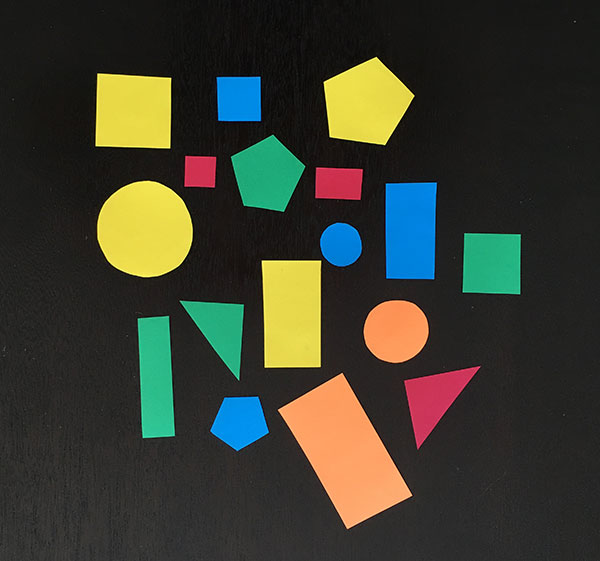

In [2]:
Image(filename="../Data/sandbox_data/shapes_and_colors.jpg", width=500)

**Goals**
1. detect the outline of each shape in the image
2. compute the center of the contour — also called the centroid of the region.

**Steps**
1. Convert to grayscale.
2. Blur to reduce high frequency noise to make our contour detection process more accurate.
3. Binarize of the image. Typically edge detection and thresholding are used for this process.

In [3]:
image = cv2.imread("../Data/Calindrinia/C_spergularina_lph133_A16_LD_1778_14_step2.tif")
shapes = cv2.imread("../Data/sandbox_data/shapes_and_colors.jpg")

grayshapes = cv2.cvtColor(shapes, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurredshapes = cv2.GaussianBlur(grayshapes, (5, 5), 0)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

threshshapes = cv2.threshold(src=blurredshapes, thresh=60, maxval=255, type=cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(src=blurred, thresh=60, maxval=255, type=cv2.THRESH_BINARY)[1]

C, blocksize = 2, 11

MAthresh = cv2.adaptiveThreshold(src=blurredshapes, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                thresholdType=cv2.THRESH_BINARY, blockSize=blocksize, C=C)
MAthresh = cv2.adaptiveThreshold(src=blurred, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                thresholdType=cv2.THRESH_BINARY, blockSize=blocksize, C=C)

GAthresh = cv2.adaptiveThreshold(src=blurredshapes, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                thresholdType=cv2.THRESH_BINARY, blockSize=blocksize, C=C)
GAthresh = cv2.adaptiveThreshold(src=blurred, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                thresholdType=cv2.THRESH_BINARY, blockSize=blocksize, C=C)

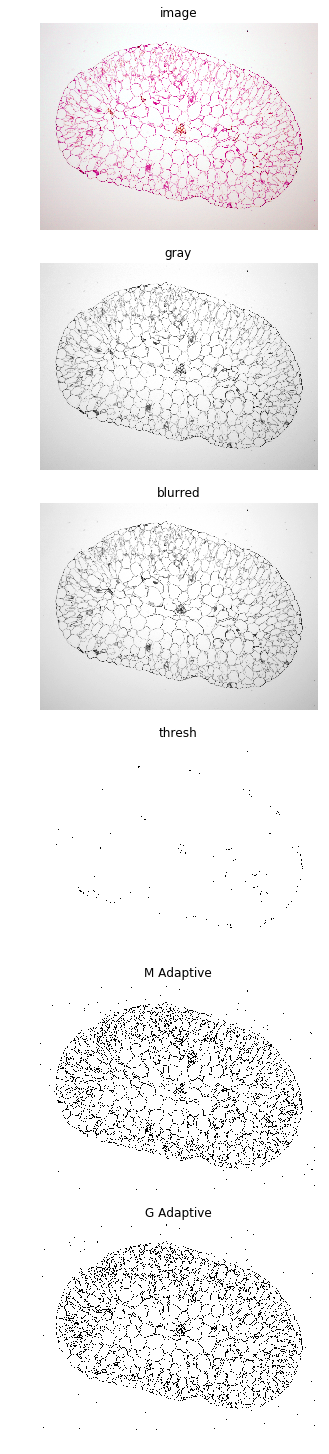

In [4]:
images = [image, gray, blurred, thresh, MAthresh, GAthresh]
titles = ["image", "gray", "blurred", "thresh", "M Adaptive", "G Adaptive"]

fig, ax = plt.subplots(nrows=len(images), ncols=1, figsize=(20, 20))

for i, title in enumerate(titles):
    ax[i].imshow(images[i], vmin=0, vmax=255, cmap="gray")
    ax[i].axis('off')
    ax[i].set_title(titles[i])
    
plt.tight_layout(pad=0.0, h_pad=0.0, w_pad=-2.0)

Now to get the contours and plot.

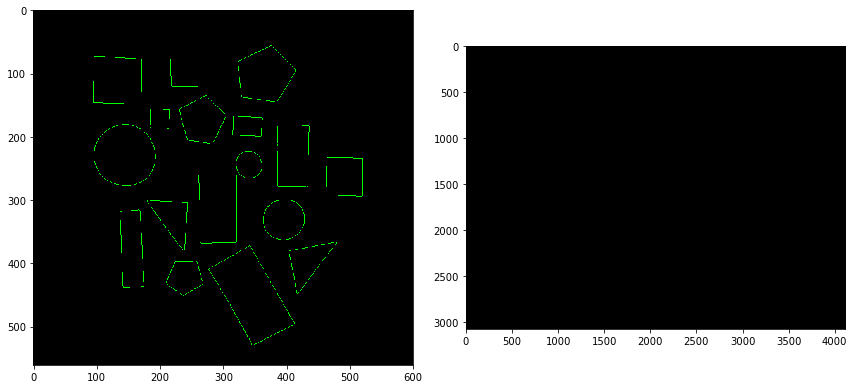

In [5]:
contoursshapes = cv2.findContours(threshshapes.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoursshapes = imutils.grab_contours(contoursshapes)

contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
canvasshapes = np.zeros_like(shapes)
cv2.drawContours(canvasshapes, contoursshapes, -1, (0, 255, 0), 1)
ax[0].imshow(canvasshapes)

canvas = np.zeros_like(image)
cv2.drawContours(canvas, contours, -1, (0, 255, 0), 1)
ax[1].imshow(canvas)
plt.tight_layout()

**Code below will take a long time to run with current image. Use with shape image only**

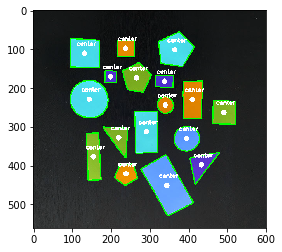

In [6]:
MIN_THRESH = 1
# loop over the contours
for c in contoursshapes:
    if cv2.contourArea(c) > MIN_THRESH:
        # process the contour
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # draw the contour and center of the shape on the image
        cv2.drawContours(shapes, [c], -1, (0, 255, 0), 2)
        cv2.circle(shapes, (cX, cY), 7, (255, 255, 255), -1)
        cv2.putText(shapes, "center", (cX - 20, cY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # show the image
        plt.imshow(shapes)

Now trying to follow [this post](https://stackoverflow.com/questions/46036172/irregular-shape-detection-and-measurement-in-python-opencv)

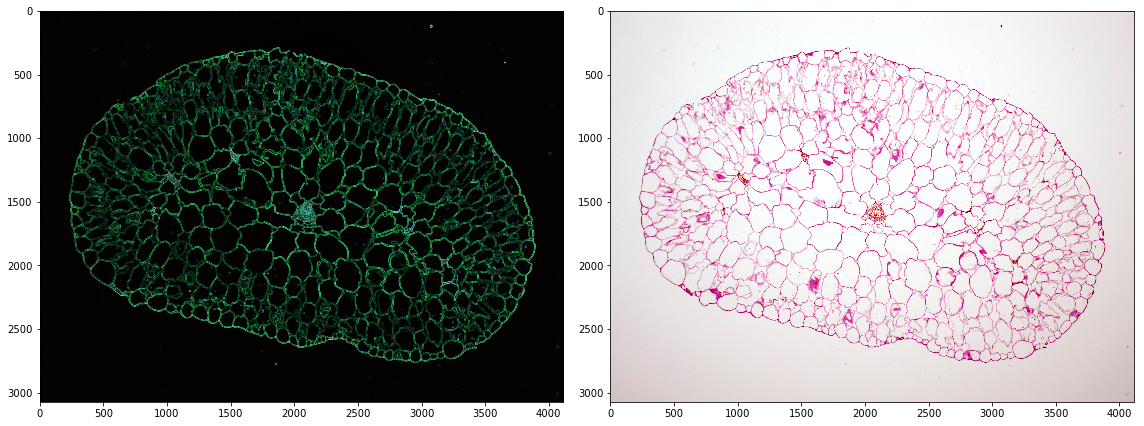

In [7]:
image = cv2.imread("../Data/Calindrinia/C_spergularina_lph133_A16_LD_1778_14_step2.tif")
neg = cv2.bitwise_not(image)
blur = cv2.GaussianBlur(neg, (7, 7), 2)
h, w = neg.shape[:2]

"""Morphological gradient"""
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(gradient)
ax[1].imshow(image)
plt.tight_layout()

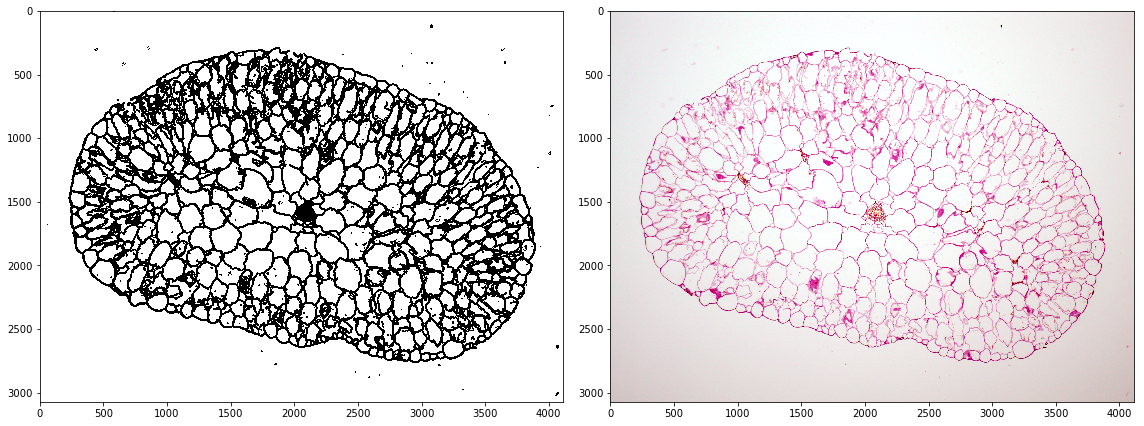

In [8]:
"""Binarize gradient"""
lowerb = np.array([0, 0, 0])
upperb = np.array([15, 15, 15])
binary = cv2.inRange(gradient, lowerb, upperb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(binary, cmap="gray")
ax[1].imshow(image)
plt.tight_layout()

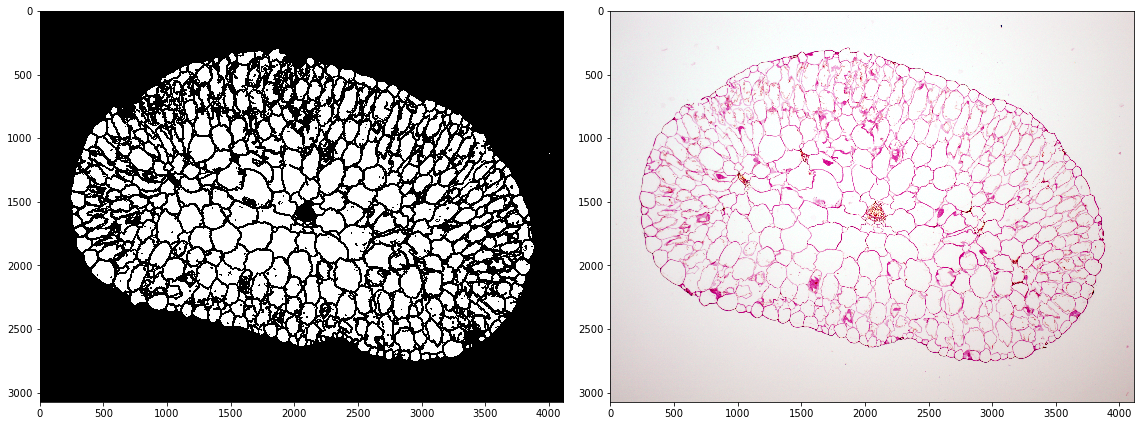

In [9]:
"""Flood fill from the edges to remove edge crystals"""
for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)

for col in range(w):
    if binary[0, col] == 255:
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)
        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(binary, cmap="gray")
ax[1].imshow(image)
plt.tight_layout()

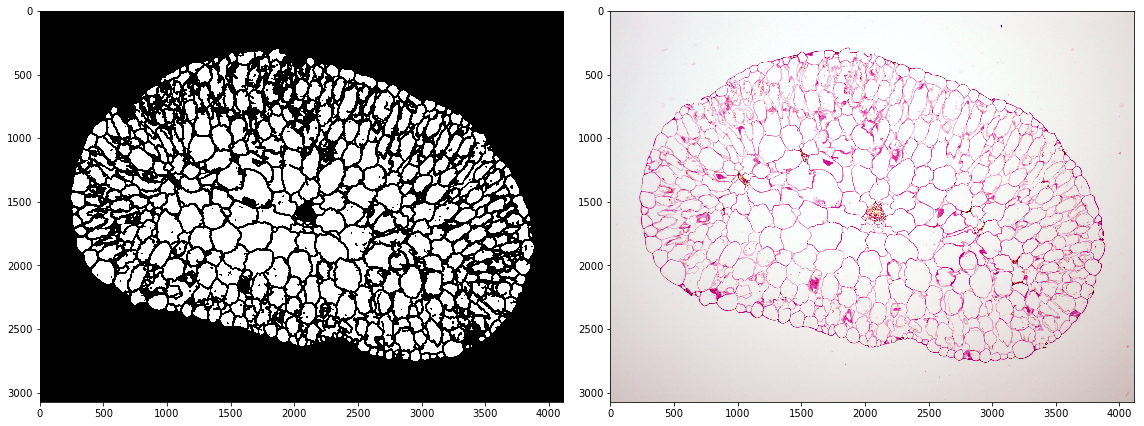

In [10]:
"""Cleaning up mask"""
foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(foreground, cmap="gray")
ax[1].imshow(image)
plt.tight_layout()

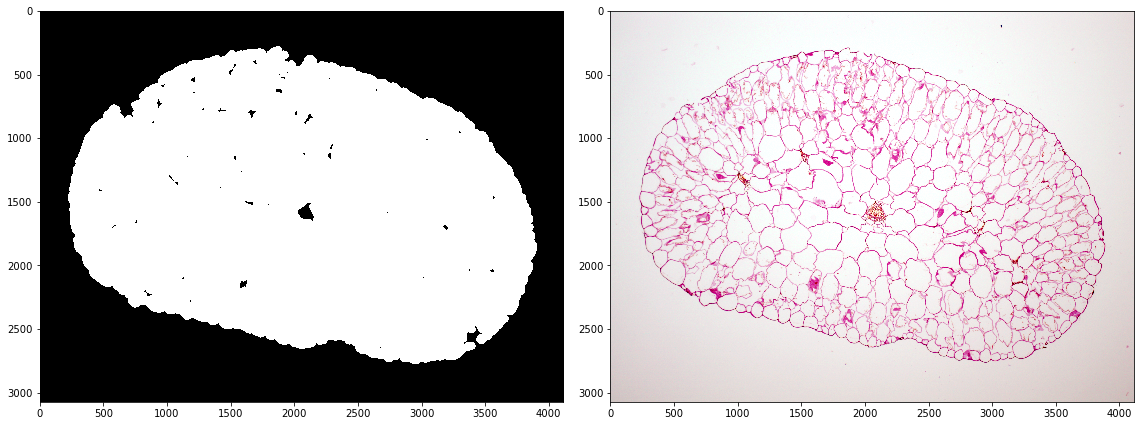

In [11]:
"""Creating background and unknown mask for labeling"""
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
background = cv2.dilate(foreground, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(background, cmap="gray")
ax[1].imshow(image)
plt.tight_layout()

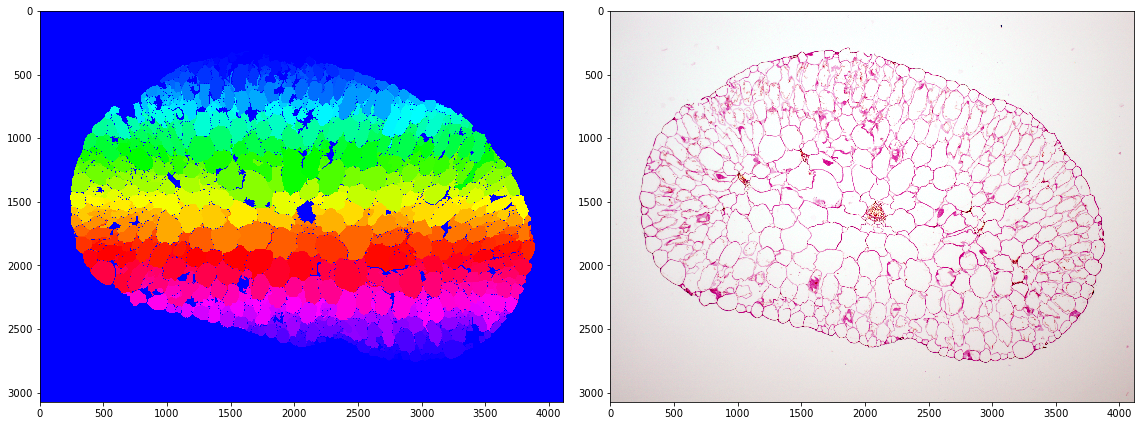

In [12]:
"""Watershed"""
markers = cv2.connectedComponents(foreground)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(image, markers)

"""Assign the markers a hue between 0 and 179"""

hue_markers = np.uint8(179*np.float32(markers)/np.max(markers))
blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(marker_img, cmap="gray")
ax[1].imshow(image)
plt.tight_layout()

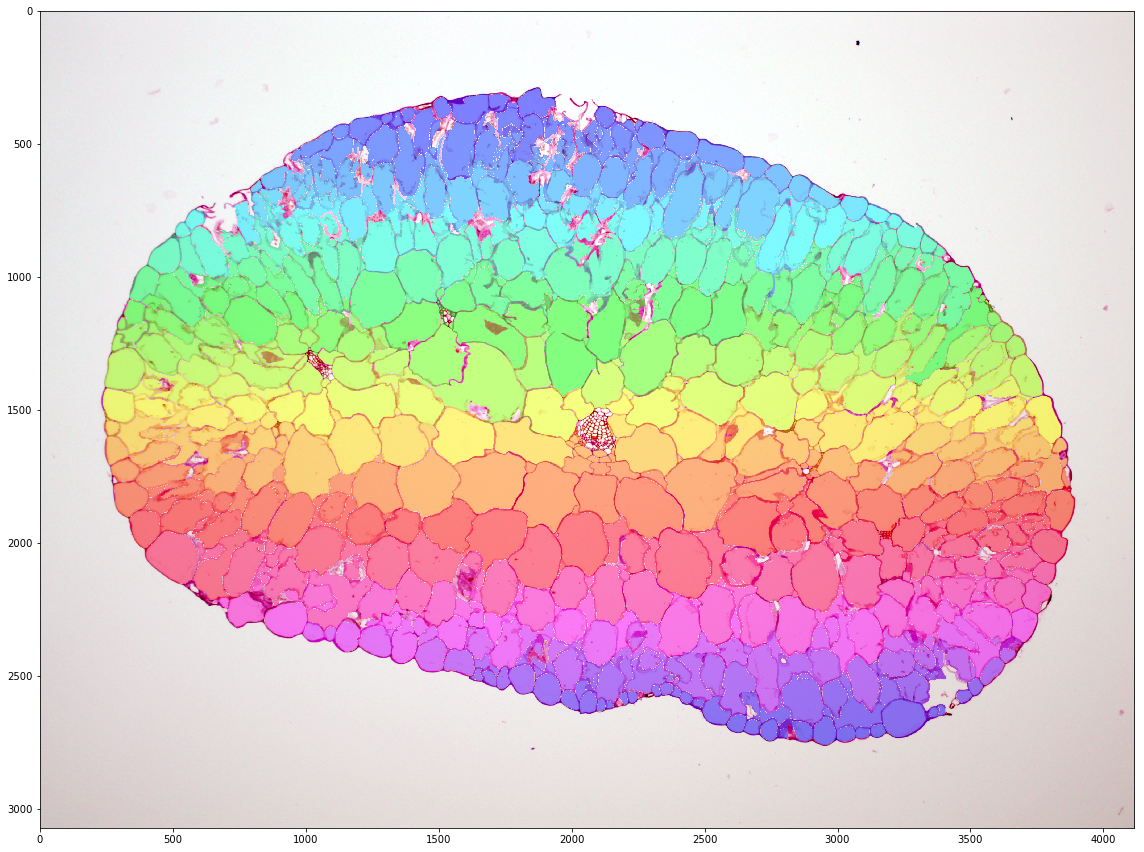

In [13]:
"""Label the original image with the watershed markers"""
labeled_img = image.copy()
labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
labeled_img = cv2.addWeighted(image, 0.5, labeled_img, 0.5, 0)

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(labeled_img)
plt.tight_layout()